### Feature Extraction Using STFT

In [17]:
import os
import numpy as np
from scipy.signal import stft
import pandas as pd
import glob


In [18]:
def segmenting(df, window_size, window_step):
    windows = []
    time_metadata = []
    for start in range(0, len(df), window_step):
        end = start + window_size
        if end <= len(df):
            window = df.iloc[start:end]['beam [Pa]'].values
            windows.append(window)
            start_time = df.index[start]
            end_time = df.index[end - 1]
            time_metadata.append((start_time, end_time))
    return windows, time_metadata

In [19]:
def apply_stft_and_save(signal_windows, time_metadata, output_dir, n_fft=254, hop_length=96, base_name='signal'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    metadata = []
    for i, (window, (start_time, end_time)) in enumerate(zip(signal_windows, time_metadata)):
        # Apply STFT using scipy
        f, t, Zxx = stft(window, nperseg=n_fft, noverlap=n_fft - hop_length)

        # Add a new axis to Zxx
        Zxx_with_new_axis = Zxx[..., np.newaxis]

        # Print the shape of each window's STFT result
        print(f"Shape of window {i}: {Zxx_with_new_axis.shape}")

        # Save the STFT result with the new axis
        output_file_path = os.path.join(output_dir, f"{base_name}_window_{i}.npy")
        np.save(output_file_path, Zxx_with_new_axis)

        metadata.append({
            'window_index': i,
            'start_time': str(start_time),
            'end_time': str(end_time),
            'file_path': output_file_path,
        })

    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_csv(os.path.join(output_dir, f"{base_name}_metadata.csv"), index=False)

In [21]:
input_folder = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/raw/BEST_BEAM_TRAIN_TEST_CSV'  # Update with your folder path
output_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/try'  # Update with your desired output path
window_size = 3000
window_step = 3000
n_fft = 254
hop_length = 98

# Process each CSV file in the input folder
for file_path in glob.glob(os.path.join(input_folder, '*.csv')):
    # Load the data
    df = pd.read_csv(file_path)

    # Segment the data
    windows, time_metadata = segmenting(df, window_size, window_step)

    # Apply STFT and save the results
    # Extracting a base name from the file path to name the output
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    apply_stft_and_save(windows, time_metadata, output_dir, n_fft=n_fft, hop_length=hop_length, base_name=base_name)

Shape of window 0: (128, 32, 1)
Shape of window 1: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 1: (128, 32, 1)
Shape of window 2: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 1: (128, 32, 1)
Shape of window 2: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 1: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 1: (128, 32, 1)
Shape of window 2: (128, 32, 1)
Shape of window 3: (128, 32, 1)
Shape of window 4: (128, 32, 1)
Shape of window 0: (128, 32, 1)
Shape of window 1: (128, 32, 1)
Shape of window 2: (128, 32, 1)
Shape of window 3: (128, 32, 1)
Shape of window 4: (128, 32, 1)
Shape of window 5: (128, 32, 1)
Shape of window 6: (128, 32, 1)
Shape of window 7: (128, 32, 1)
Shape of

In [64]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import glob

def load_and_stack_npy(directory):
    files = glob.glob(f'{directory}/*.npy')
    sorted_files = sorted(files, key=lambda x: x.split('/')[-1])
    data_arrays = [np.load(file) for file in sorted_files]
    return np.stack(data_arrays)

# Directory containing your .npy files
data_directory = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/SCIPY_N'  # Replace with your directory path

# Load data
data = load_and_stack_npy(data_directory)

np.save('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/train_test_N_SCIPY.npy', data)

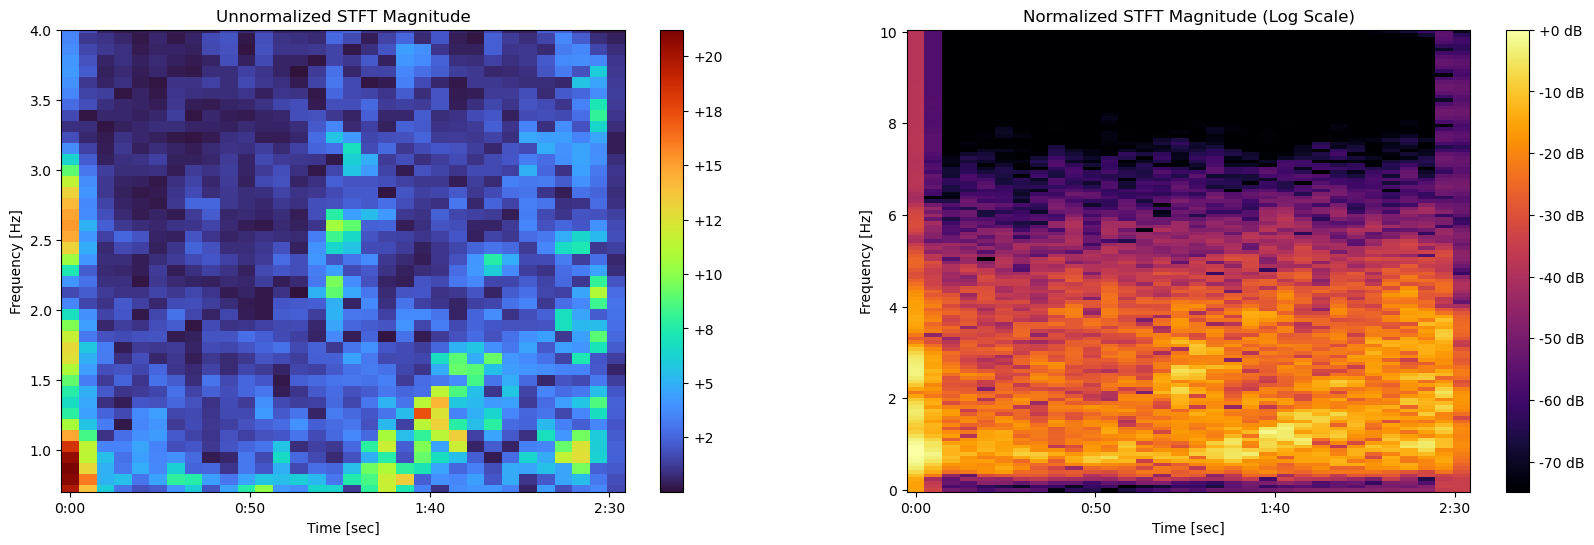

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import librosa.display

# Load your data
df = pd.read_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/raw/BEST_BEAM_TRAIN_TEST_CSV/2018-11-27_13-05-01.csv')
signal = df['beam [Pa]'].values  # Extract only the signal values
normalized_signal = librosa.util.normalize(signal)

# Define STFT parameters
n_fft = 254
hop_length = 98

# Define your signal's sample rate
sample_rate = 20

# Calculate the Short-Time Fourier Transform (STFT) using SciPy
frequencies, times, Zxx = scipy.signal.stft(signal, fs=sample_rate, nperseg=n_fft, noverlap=n_fft - hop_length)
_, _, Zxx_normalized = scipy.signal.stft(normalized_signal, fs=sample_rate, nperseg=n_fft, noverlap=n_fft - hop_length)

# Convert amplitude to dB for the normalized plot
Zxx_normalized_db = librosa.amplitude_to_db(np.abs(Zxx_normalized), ref=np.max)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot the unnormalized STFT magnitude
img1 = librosa.display.specshow(np.abs(Zxx), sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='turbo', ax=ax[0])
ax[0].set_title('Unnormalized STFT Magnitude')
ax[0].set_xlabel('Time [sec]')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_ylim(0.7, 4)
fig.colorbar(img1, ax=ax[0], format='%+2.0f')  # Add colorbar to the first plot

# Plot the normalized STFT magnitude with log scale normalization
img2 = librosa.display.specshow(Zxx_normalized_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='inferno', ax=ax[1])
ax[1].set_title('Normalized STFT Magnitude (Log Scale)')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Frequency [Hz]')

fig.colorbar(img2, ax=ax[1], format='%+2.0f dB')  # Add colorbar to the second plot

plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/processed2_stft/VALID_non_overlap_datetime.csv')

# Convert the "start_time" column to a numpy array of UTC datetime objects
start_time_array = pd.to_datetime(df['start_time']).to_numpy()
print(start_time_array)

# Save the numpy array as a .npy file
np.save('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/processed2_stft/VALID_Non_Overlap.npy', start_time_array)